In [1]:
import pandas as pd
import numpy as np
import pylab as py

%matplotlib inline

fdata = pd.read_csv("Fraud_Data.csv")
ipdata = pd.read_csv("IpAddress_to_Country.csv")

# convert timestamp string to pd.timestamp
fdata.signup_time = fdata.signup_time.apply(pd.Timestamp)
fdata.purchase_time = fdata.purchase_time.apply(pd.Timestamp)

# rename class because that's a reserved word
fdata.rename(columns={'class':'fraud'}, inplace=True)

In [45]:
fdata.head(1)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,fraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0


In [46]:
ipdata.head(1)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia


In [47]:
print fdata.shape, ipdata.shape

(151112, 11) (138846, 3)


In [48]:
## confirm user_id is unique across rows
print fdata.loc[fdata.duplicated('user_id')]

Empty DataFrame
Columns: [user_id, signup_time, purchase_time, purchase_value, device_id, source, browser, sex, age, ip_address, fraud]
Index: []


In [49]:
## confirm there is no overlap in ip address
ipdata.sort_values(by='lower_bound_ip_address', inplace=True)
diff = ipdata.shift(-1).lower_bound_ip_address-ipdata.upper_bound_ip_address
print diff.min()

1.0


In [2]:
## assign country using searchsorted function
start_idx = np.searchsorted(ipdata['lower_bound_ip_address'], fdata['ip_address'], side='right')-1
end_idx = np.searchsorted(ipdata['upper_bound_ip_address'], fdata['ip_address'])
fdata['idx'] = [x if x==y else -1 for x, y in zip(start_idx, end_idx)]
ipdata['idx'] = ipdata.index

mdata = fdata.merge(ipdata, how='left', on='idx').drop(['user_id','lower_bound_ip_address', 'upper_bound_ip_address','idx'],axis=1)
mdata['country'] = mdata['country'].apply(lambda x: 'NA' if pd.isnull(x) else x)

In [52]:
mdata.country.value_counts()[0:5]

United States     58049
NA                21966
China             12038
Japan              7306
United Kingdom     4490
Name: country, dtype: int64

## This creates a table with country attached

In [3]:
# add time-related info
mdata['lapsed_time'] = mdata.purchase_time - mdata.signup_time
mdata['lapsed_secs'] = mdata.lapsed_time.apply(lambda x: x.seconds) #ints are easier to work with

mdata['signup_mon'] = mdata.signup_time.apply(lambda x: x.month)
mdata['purchase_mon'] = mdata.purchase_time.apply(lambda x: x.month)
mdata['signup_weekday'] = mdata.signup_time.apply(lambda x: x.weekday())
mdata['purchase_weekday'] = mdata.purchase_time.apply(lambda x: x.weekday())

# add unique counts
mdata['device_counts'] = mdata.groupby('device_id')['fraud'].transform('count')
mdata['ip_counts'] = mdata.groupby('ip_address')['fraud'].transform('count')

In [54]:
print mdata.shape

(151112, 19)


In [55]:
mdata.fraud.value_counts(dropna=False)

0    136961
1     14151
Name: fraud, dtype: int64

LEGEND: red means fraud is true, green means fraud is false.
        total  fraud      rate
source                        
Ads     59881   5513  0.092066
Direct  30616   3226  0.105370
SEO     60615   5412  0.089285
         total  fraud      rate
browser                        
Chrome   61432   6069  0.098792
FireFox  24610   2342  0.095165
IE       36727   3187  0.086775
Opera     3676    328  0.089227
Safari   24667   2225  0.090201
     total  fraud      rate
sex                        
F    62819   5717  0.091007
M    88293   8434  0.095523
     total  fraud      rate
age                        
18    2762    270  0.097755
19    2906    242  0.083276
20    3367    308  0.091476
21    3735    289  0.077376
22    4093    378  0.092353
             total  fraud      rate
lapsed_secs                        
1             7602   7600  0.999737
2                3      0  0.000000
3                1      0  0.000000
4                3      1  0.333333
6                1      0  0.000000


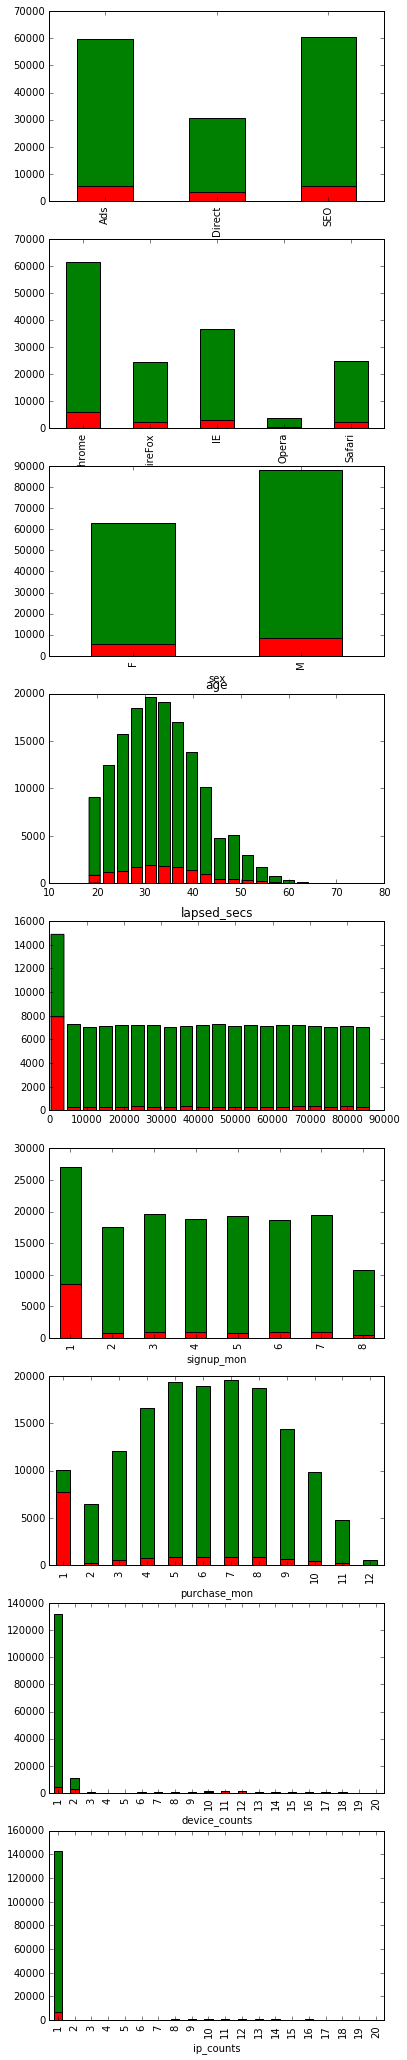

In [60]:
def bar_hist_plots (data, classvar, examvars, printtable=False):
    
    class0 = data.loc[data[classvar]==0]
    class1 = data.loc[data[classvar]==1]
    fig, ax = py.subplots(len(examvars),1, figsize=(6,4*len(examvars)))
    
    print 'LEGEND: red means', classvar, 'is true, green means', classvar, 'is false.'
    
    for idx, var in enumerate(examvars):
        
        # print frequency table with the largest positives
        if printtable:
            g = data.groupby(var)[classvar]
            t = pd.concat([g.count().rename('total'), g.sum(), g.mean().rename('rate')], axis=1)
            print t.head()
        
        # if unique values <= 20, plot bar graph; otherwise plot histogram with 20 bins
        if len(data[var].unique())<=20:
            freq = pd.concat((class1.groupby(var)[classvar].count(), class0.groupby(var)[classvar].count()), axis=1)
            freq.plot(kind='bar', stacked=True, ax=ax[idx], color=['r','g'], legend=False)
        else:
            ax[idx].hist([class1[var], class0[var]], bins=20, stacked=True, color=['r','g'])
            ax[idx].set_title(var)

examvars = ['source','browser','sex','age','lapsed_secs','signup_mon','purchase_mon','device_counts','ip_counts']
bar_hist_plots (mdata, 'fraud', examvars, True)

## If lapsed seconds <= 1, very likely to be fraud. If signup or purchase is in Jan, likely to be fraud. If device or ip counts >=2, very likely to be fraud


In [22]:
top_countries = mdata.country.value_counts()[0:19]
mdata['country_top'] = mdata.country.apply(lambda x: x if x in top_countries else 'other')
mdata['lapsed_1sec'] = mdata.lapsed_secs<=1

In [23]:
X = mdata[['purchase_value','source','sex','age','lapsed_1sec','device_counts','ip_counts','country_top']]
X = pd.get_dummies(X)
y = np.ravel(mdata[['fraud']])
print X.shape, y.shape

(151112, 30) (151112,)


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

dt = DecisionTreeClassifier()
f1_scorer = make_scorer(f1_score)

params = {'max_depth':[4,5,6,7], 'min_samples_split':[2,3,4]}

clf = GridSearchCV(estimator=dt, param_grid=params, scoring=f1_scorer)
clf.fit(X_train, y_train)

print(clf.best_params_)

dt = clf.best_estimator_

print f1_score(y_train, dt.predict(X_train))
print f1_score(y_test, dt.predict(X_test))

print confusion_matrix(y_train, dt.predict(X_train))
print confusion_matrix(y_test, dt.predict(X_test))

{'min_samples_split': 2, 'max_depth': 4}
0.69474849342
0.710641399417
[[102721      0]
 [  4964   5649]]
[[34240     0]
 [ 1588  1950]]


In [25]:
# Print the feature ranking
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))


Feature ranking:
1. lapsed_1sec (0.933992)
2. device_counts (0.057515)
3. source_Direct (0.005313)
4. ip_counts (0.002983)
5. purchase_value (0.000171)
6. age (0.000026)
7. country_top_United States (0.000000)
8. source_Ads (0.000000)
9. source_SEO (0.000000)
10. sex_F (0.000000)
11. sex_M (0.000000)
12. country_top_Australia (0.000000)
13. country_top_Brazil (0.000000)
14. country_top_Canada (0.000000)
15. country_top_China (0.000000)
16. country_top_other (0.000000)
17. country_top_Germany (0.000000)
18. country_top_India (0.000000)
19. country_top_Italy (0.000000)
20. country_top_Japan (0.000000)
21. country_top_Korea Republic of (0.000000)
22. country_top_Mexico (0.000000)
23. country_top_NA (0.000000)
24. country_top_Netherlands (0.000000)
25. country_top_Russian Federation (0.000000)
26. country_top_Spain (0.000000)
27. country_top_Sweden (0.000000)
28. country_top_Taiwan; Republic of China (ROC) (0.000000)
29. country_top_United Kingdom (0.000000)
30. country_top_France (0.00000

In [26]:
export_graphviz(dt, out_file='tree.dot',feature_names = X.columns)

    p_thres       fpr       tpr
0  1.000000  0.000000  0.551159
1  0.355596  0.010164  0.594969
2  0.201737  0.061682  0.717354
3  0.051084  0.080053  0.723007
4  0.045064  0.084609  0.726116
5  0.031918  0.243662  0.771905
6  0.030354  0.888668  0.966930
7  0.028986  0.889603  0.967496
8  0.026652  1.000000  0.999717
9  0.000000  1.000000  1.000000


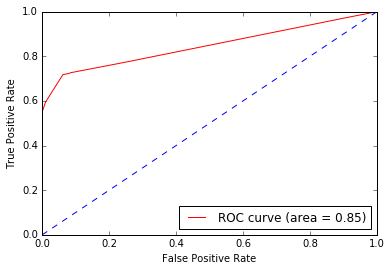

In [47]:
from sklearn.metrics import roc_curve, auc

preds = dt.predict_proba(X_test)[:,1]
fpr, tpr, thres = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

py.plot(fpr, tpr, color='r', label='ROC curve (area = %0.2f)' % roc_auc)
py.plot([0, 1], [0, 1], color='b', linestyle='--')
py.legend(loc="lower right")
py.xlabel('False Positive Rate')
py.ylabel('True Positive Rate')

print pd.DataFrame(np.transpose([thres, fpr, tpr]), columns=['p_thres','fpr','tpr'])

## The best cutoff p would be 0.2, because it has a low false pos rate and high true pos rate

In [72]:
def g(x):
    return int(x)
f = np.vectorize(g)

ypred_train = f(dt.predict_proba(X_train)[:,1]>=0.36)
ypred_test = f(dt.predict_proba(X_test)[:,1]>=0.36)

print ypred_train

print f1_score(y_train, ypred_train)
print f1_score(y_test, ypred_test)

print confusion_matrix(y_train, ypred_train)
print confusion_matrix(y_test, ypred_test)

[0 0 0 ..., 0 0 0]
0.69474849342
0.710641399417
[[102721      0]
 [  4964   5649]]
[[34240     0]
 [ 1588  1950]]
